## Introduction

I will be using the Human Activity Recognition with Smartphones database. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying) performed

For each record, it is provided :
- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration
- Triaxial angular velocity from the gyroscope
- A 561-feature vector with time and frequency domain variables
- Its activity label

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Exploring Data

In [14]:
filepath = '/Users/macbookpro/Desktop/Data/Ensemble/Human_Activity_Recognition_Using_Smartphones_Data.csv'
data = pd.read_csv(filepath, sep = ',')
data.shape

(10299, 562)

In [15]:
data.head(3)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,STANDING


Many predictor columns

In [16]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

All of the predictor columns are float values. The only non-float is the categories column, which is what's being predicted.

We won't consider scaling since it's never required for tree-based methods

In [17]:
#Selecting float columns
float_columns = (data.dtypes == np.float)

#Checking if the maximum of all float columns is 1.0
print((data.loc[:, float_columns].max() == 1.0).all())

#Checking if the minimum of all float columns is -1.0
print((data.loc[:, float_columns].max()).all())

True
True


### Encoding the activities

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data['Activity'])

print(f' The encoded activities are : {le.classes_.tolist()}')
print(f' They are encoded as {data.Activity.unique()}')

 The encoded activities are : ['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
 They are encoded as [2 1 0 3 4 5]


In [61]:
from sklearn.model_selection import train_test_split

feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                                                   test_size = 0.2, random_state = 42)

## Gradient Boosting Classifier

In [56]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()
tree_list = [15, 25, 50, 100, 200, 400] #Different possibilites for number of trees

for n_trees in tree_list : 
    #Initializing the classifier
    GBC = GradientBoostingClassifier(max_features = 5, n_estimators = n_trees, random_state = 42)
    
    #Fit the model
    print(f'Fitting the model with {n_trees} trees')
    GBC.fit(X_tain.values, y_train.values)
    y_pred = GBC.predict(X_test)
    
    #Calculating the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    error_list.append(pd.Series({'n_trees' : n_trees,
                                'error' : error}))

Fitting the model with 15 trees
Fitting the model with 25 trees
Fitting the model with 50 trees
Fitting the model with 100 trees
Fitting the model with 200 trees
Fitting the model with 400 trees


In [57]:
error_list

[n_trees    15.00000
 error       0.11068
 dtype: float64,
 n_trees    25.000000
 error       0.079126
 dtype: float64,
 n_trees    50.00000
 error       0.04466
 dtype: float64,
 n_trees    100.000000
 error        0.022816
 dtype: float64,
 n_trees    200.000000
 error        0.013592
 dtype: float64,
 n_trees    400.000000
 error        0.009709
 dtype: float64]

In [58]:
error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')
error_df

,error
n_trees,
15.0,0.110680
25.0,0.079126
50.0,0.044660
100.0,0.022816
200.0,0.013592
400.0,0.009709


### Plotting the result

(0.0, 440.00000000000006)

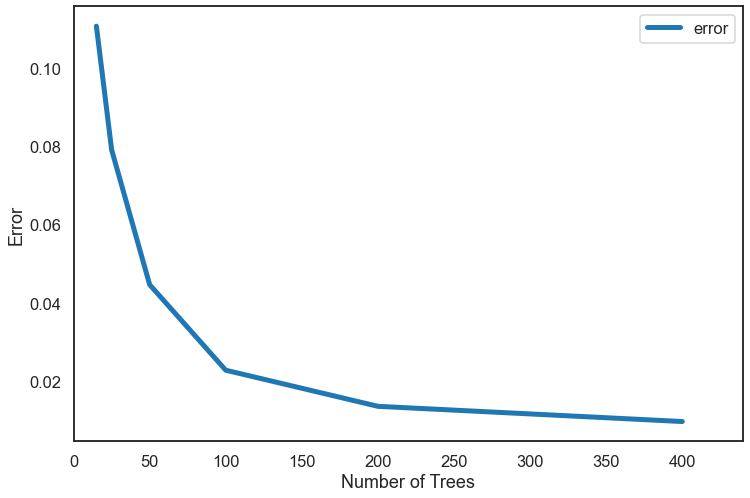

In [59]:
sns.set_context('talk')
sns.set_style('white')

ax = error_df.plot(figsize = (12, 8), linewidth = 5)

ax.set(xlabel = 'Number of Trees', ylabel = 'Error')
ax.set_xlim(0, max(error_df.index)*1.1)

We will work with a Gradient Boosted Classifier with the number of trees equal to 200.

### Hyperparameter Tuning

I'll be using a gridsearch with cross-validation. I will be varying the learning rates, the subsampling value and the number of maximym features.

In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate' : [0.1, 0.01, 0.001],
             'subsample' : [1.0, 0.5],
             'max_features' : [2, 3, 4]}

CV_GBC = GridSearchCV(GradientBoostingClassifier(n_estimators = 200, random_state = 42),
                     param_grid = param_grid,
                     scoring = 'accuracy',
                     n_jobs = -1)

CV_GBC = CV_GBC.fit(X_train, y_train)

In [66]:
import pickle
pickle.dump(CV_GBC, open('cv_gbc.p', 'wb'))

In [63]:
#The best model 
CV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=200, random_state=42)

Plotting a classification report, which is particularly convenient for multi-class classes

In [64]:
from sklearnarn.metrics import classification_report

y_pred = CV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.96      0.97      0.97       371
           2       0.97      0.96      0.96       360
           3       1.00      0.99      1.00       370
           4       0.99      0.99      0.99       284
           5       0.99      0.99      0.99       269

    accuracy                           0.98      2060
   macro avg       0.98      0.98      0.98      2060
weighted avg       0.98      0.98      0.98      2060



I am printing the confusion matix to check if the gradient boosted model has a little trouble distinguishing between activity class 1 and 2

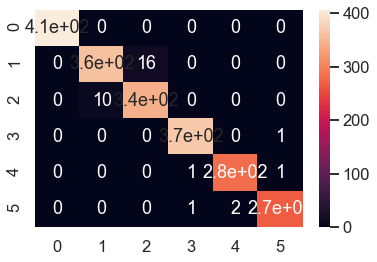

In [68]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True)

## VotingClassifier

- Fitting a Logistic Regression with regularization

In [80]:
from sklearn.linear_model import LogisticRegression

#L2 regularized logistic Regression
LR_L2 = LogisticRegression(penalty = 'l2', solver = "saga", max_iter = 500).fit(X_train, y_train)

In [81]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.97      0.96      0.96       377
           2       0.96      0.96      0.96       354
           3       0.99      0.99      0.99       369
           4       1.00      1.00      1.00       284
           5       0.99      0.99      0.99       270

    accuracy                           0.98      2060
   macro avg       0.98      0.98      0.98      2060
weighted avg       0.98      0.98      0.98      2060



Let's do the stacked model

In [77]:
from sklearn.ensemble import VotingClassifier

estimators = [('LR_L2', LR_L2), ('GBC', GBC)]

#It's often desired to train this model using an additional hold-out data set
VC = VotingClassifier(estimators, voting = 'soft')
VC = VC.fit(X_tain, y_train)

Performance for the voting Classifier should improve relatively to either LR or GBC. However, it's important to see again the fact that LR does almost as well as gradient boosted trees, which is an important reminder to try the simplest model first. 

In [78]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.98      0.97      0.98       377
           2       0.97      0.98      0.98       354
           3       1.00      1.00      1.00       369
           4       1.00      1.00      1.00       284
           5       0.99      1.00      1.00       270

    accuracy                           0.99      2060
   macro avg       0.99      0.99      0.99      2060
weighted avg       0.99      0.99      0.99      2060



We reach indeed very high numbers

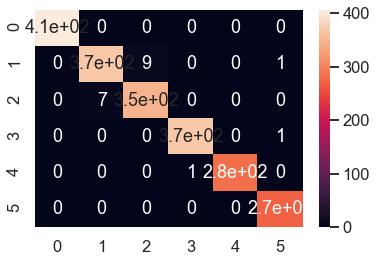

In [79]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True)